In [1]:
%load_ext autoreload
%load_ext autotime

time: 375 µs (started: 2023-06-20 10:19:44 -07:00)


In [2]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

time: 659 µs (started: 2023-06-20 10:19:44 -07:00)


In [3]:
import dask
import dask.dataframe as dd
import json
import numpy as np
import pandas as pd
from dask import compute, delayed
from dask.distributed import Client, Future, LocalCluster, as_completed, get_client, wait
from typing import Union

time: 4.64 s (started: 2023-06-20 10:19:44 -07:00)


In [4]:
client = Client(LocalCluster(n_workers=16, local_directory=f"/var/tmp/playground-cm1-multiple"))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 48,Total memory: 125.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36623,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 125.47 GiB
Comm: tcp://127.0.0.1:35073,Total threads: 3
Dashboard: http://127.0.0.1:39597/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:44197,


time: 3.49 s (started: 2023-06-20 10:19:49 -07:00)


In [5]:
log_dir = "/p/vast1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet"

time: 674 µs (started: 2023-06-20 10:19:53 -07:00)


In [6]:
all_view = dd.read_parquet(f"{log_dir}/*.parquet").compute()
all_view

,index,proc,rank,thread_id,cat,io_cat,tstart,tend,func_id,level,...,app,proc_name,file_name,size,acc_pat,bandwidth,duration,tmid,file_id,proc_id
0,1,1,0,322192,0,3,2.823260,2.823267,__xstat,0,...,app1,app1#localhost#0#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000007,28232634,4531734244992817467,-929352282003150188
1,2,1,0,322192,0,3,2.823293,2.823305,open,0,...,app1,app1#localhost#0#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000012,28232988,4531734244992817467,-929352282003150188
2,3,1,0,322192,0,3,2.823371,2.823373,__fxstat,0,...,app1,app1#localhost#0#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000002,28233717,4531734244992817467,-929352282003150188
3,4,1,0,322192,0,1,2.823390,2.823399,read,0,...,app1,app1#localhost#0#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,16777216,0,1758241.75,0.000009,28233943,4531734244992817467,-929352282003150188
4,5,1,0,322192,0,3,2.823490,2.823494,close,0,...,app1,app1#localhost#0#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000004,28234916,4531734244992817467,-929352282003150188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27458,27459,1,1279,322192,0,3,2.797101,2.797108,__xstat,0,...,app1,app1#localhost#1279#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000007,27971043,4531734244992817467,-929352281919329644
27459,27460,1,1279,322192,0,3,2.797126,2.797140,open,0,...,app1,app1#localhost#1279#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000014,27971328,4531734244992817467,-929352281919329644
27460,27461,1,1279,322192,0,3,2.797208,2.797210,__fxstat,0,...,app1,app1#localhost#1279#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,0,0,0.00,0.000002,27972087,4531734244992817467,-929352281919329644
27461,27462,1,1279,322192,0,1,2.797228,2.797238,read,0,...,app1,app1#localhost#1279#35184372411024,/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_fil...,16777216,0,1600000.00,0.000010,27972326,4531734244992817467,-929352281919329644


time: 1.58 s (started: 2023-06-20 10:19:53 -07:00)


In [7]:
from enum import Enum


class AccessPattern(Enum):
    SEQUENTIAL = 0
    RANDOM = 1


class IOCategory(Enum):
    READ = 1
    WRITE = 2
    METADATA = 3


CAT_POSIX = 0
TIME_PRECISION = 1e7

VIEW_TYPES = ['trange', 'file_name', 'proc_name']
LOGICAL_VIEW_TYPES = ['app_name', 'node_name', 'rank', 'file_dir', 'file_regex']

ACC_PAT_SUFFIXES = ['time', 'size', 'count']
APP_NAME_COL = 'app_name'
DELTA_BINS = [
    0,
    0.001,
    0.01,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9
]
DELTA_BIN_NAMES = [
    'none',
    'trivial',
    'very low',
    'low',
    'medium',
    'high',
    'very high',
    'critical'
]
DERIVED_MD_OPS = ['close', 'open', 'seek', 'stat']
FILE_COL = 'file_name'
FILE_DIR_COL = 'file_dir'
FILE_REGEX_COL = 'file_regex'
FILE_REGEX_PLACEHOLDER = '[0-9]'
HLM_AGG = {
    'duration': [sum],
    'index': ['count'],
    'size': [min, max, sum],
}
IO_CATS = [io_cat.value for io_cat in list(IOCategory)]
IO_TYPES = ['read', 'write', 'metadata']
NODE_NAME_COL = 'node_name'
PROC_COL = 'proc_name'
PROC_NAME_SEPARATOR = '#'
RANK_COL = 'rank'
TRANGE_COL = 'trange'
XFER_SIZE_BINS = [
    -np.inf,
    4 * 1024.0,
    16 * 1024.0,
    64 * 1024.0,
    256 * 1024.0,
    1 * 1024.0 * 1024.0,
    4 * 1024.0 * 1024.0,
    16 * 1024.0 * 1024.0,
    64 * 1024.0 * 1024.0,
    np.inf
]
XFER_SIZE_BIN_LABELS = [
    '<4 KB',
    '4-16 KB',
    '16-64 KB',
    '64-256 KB',
    '256 KB-1 MB',
    '1-4 MB',
    '4-16 MB',
    '16-64 MB',
    '>64 MB',
]
XFER_SIZE_BIN_NAMES = [
    '<4 KB',
    '4 KB',
    '16 KB',
    '64 KB',
    '256 KB',
    '1 MB',
    '4 MB',
    '16 MB',
    '64 MB',
    '>64 MB'
]

time: 3.53 ms (started: 2023-06-20 10:19:54 -07:00)


In [8]:
def set_tranges(df: pd.DataFrame, tranges: Union[Future, np.ndarray]):
    tranges = tranges.result() if isinstance(tranges, Future) else tranges
    return df.assign(trange=np.digitize(df['tmid'], bins=tranges, right=True))


def _compute_tranges(global_min_max: dict, precision=TIME_PRECISION):
    tmid_min, tmid_max = global_min_max['tmid']
    tranges = np.arange(tmid_min, tmid_max, precision)
    return get_client().scatter(tranges)


def _flatten_column_names(ddf: dd.DataFrame):
    ddf.columns = ['_'.join(tup).rstrip('_') for tup in ddf.columns.values]
    return ddf


def _set_derived_columns(ddf: dd.DataFrame):
    # Derive `io_cat` columns
    for col_suffix, col_value in zip(['time', 'size', 'count'], ['duration_sum', 'size_sum', 'index_count']):
        for io_cat in list(IOCategory):
            col_name = f"{io_cat.name.lower()}_{col_suffix}"
            ddf[col_name] = 0.0 if col_suffix is 'time' else 0
            ddf[col_name] = ddf[col_name].mask(ddf['io_cat'] == io_cat.value, ddf[col_value])
    for io_cat in list(IOCategory):
        min_name, max_name = f"{io_cat.name.lower()}_min", f"{io_cat.name.lower()}_max"
        ddf[min_name] = 0
        ddf[max_name] = 0
        ddf[min_name] = ddf[min_name].mask(ddf['io_cat'] == io_cat.value, ddf['size_min'])
        ddf[max_name] = ddf[max_name].mask(ddf['io_cat'] == io_cat.value, ddf['size_max'])
    # Derive `data` columns
    ddf['data_count'] = ddf['write_count'] + ddf['read_count']
    ddf['data_size'] = ddf['write_size'] + ddf['read_size']
    ddf['data_time'] = ddf['write_time'] + ddf['read_time']
    # Derive `acc_pat` columns
    for col_suffix, col_value in zip(ACC_PAT_SUFFIXES, ['data_time', 'data_size', 'data_count']):
        for acc_pat in list(AccessPattern):
            col_name = f"{acc_pat.name.lower()}_{col_suffix}"
            ddf[col_name] = 0.0 if col_suffix is 'time' else 0
            ddf[col_name] = ddf[col_name].mask(ddf['acc_pat'] == acc_pat.value, ddf[col_value])
    # Derive metadata operation columns
    for col_suffix, col_value in zip(['time', 'count'], ['duration_sum', 'index_count']):
        for md_op in DERIVED_MD_OPS:
            col_name = f"{md_op}_{col_suffix}"
            ddf[col_name] = 0.0 if col_suffix is 'time' else 0
            if md_op in ['close', 'open']:
                ddf[col_name] = ddf[col_name].mask(ddf['func_id'].str.contains(md_op) & ~ddf['func_id'].str.contains('dir'), ddf[col_value])
            else:
                ddf[col_name] = ddf[col_name].mask(ddf['func_id'].str.contains(md_op), ddf[col_value])
    # --- New columns ---
    ddf['bw'] = ddf['size_sum'] / ddf['duration_sum']
    ddf['iops'] = ddf['index_count'] / ddf['duration_sum']
    ddf['intensity'] = 0.0
    ddf['intensity'] = ddf['intensity'].mask(ddf['size_sum'] > 0, ddf['index_count'] / ddf['size_sum'])
    # ---
    # Return ddf
    return ddf

time: 28.2 ms (started: 2023-06-20 10:19:54 -07:00)


In [9]:
def load_global_min_max(log_dir: str) -> dict:
    with open(f"{log_dir}/global.json") as file:
        global_min_max = json.load(file)
    return global_min_max


def compute_main_view(
    log_dir: str,
    global_min_max: dict,
    view_types: list,
) -> dd.DataFrame:
    # Read Parquet files
    ddf = dd.read_parquet(f"{log_dir}/*.parquet")
    # Fix dtypes
    ddf['acc_pat'] = ddf['acc_pat'].astype(np.uint8)
    ddf['duration'] = ddf['duration'].astype(np.float64)
    ddf['io_cat'] = ddf['io_cat'].astype(np.uint8)
    # Compute tranges
    tranges = _compute_tranges(global_min_max=global_min_max)
    # Add `io_cat`, `acc_pat`, and `func_id` to groupby
    extra_cols = ['io_cat', 'acc_pat', 'func_id']
    groupby = view_types.copy()
    groupby.extend(extra_cols)
    # Compute high-level metrics
    hlm_view = ddf[(ddf['cat'] == CAT_POSIX) & (ddf['io_cat'].isin(IO_CATS))] \
        .map_partitions(set_tranges, tranges=tranges) \
        .groupby(groupby) \
        .agg(HLM_AGG) \
        .reset_index() \
        .persist()
    # Flatten column names
    hlm_view = _flatten_column_names(ddf=hlm_view)
    # Set derived columns
    hlm_view = _set_derived_columns(ddf=hlm_view)
    # Compute agg_view
    main_view = hlm_view \
        .drop(columns=extra_cols) \
        .groupby(view_types) \
        .sum() \
        .persist()
    # Delete hlm_view
    del hlm_view
    # Return main_view
    return main_view

time: 3.01 ms (started: 2023-06-20 10:19:54 -07:00)


In [10]:
global_min_max = load_global_min_max(log_dir=log_dir)
global_min_max

{'file_id': [901974072163427748, 4531734248727221027],
 'proc_id': [-929352282003150188, -929352281919329644],
 'tmid': [0, 6683055996]}

time: 5.93 ms (started: 2023-06-20 10:19:55 -07:00)


In [11]:
main_view = compute_main_view(log_dir=log_dir, global_min_max=global_min_max, view_types=VIEW_TYPES)
main_view

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,metadata_size,read_count,write_count,metadata_count,read_min,read_max,write_min,write_max,metadata_min,metadata_max,data_count,data_size,data_time,sequential_time,random_time,sequential_size,random_size,sequential_count,random_count,close_time,open_time,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


time: 1.04 s (started: 2023-06-20 10:19:56 -07:00)


In [12]:
main_view['id'] = main_view.index.map(hash)

time: 19.6 ms (started: 2023-06-20 10:19:57 -07:00)


In [13]:
main_view.head()

duration_sum  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024       0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024       0.001609   
3      /dev/null                                          app1#localhost#1#35184372411024        0.000003   
                                                          app1#localhost#10#35184372411024       0.000002   
                                                          app1#localhost#100#35184372411024      0.000003   

                                                                                             index_count  \
trange file_name                                          proc_name                                        
1      /dev/null                                          app1#localhost#17#35184372411024             1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024             5   
3      /dev/null                                          app1#localhost#1#35184372411024              1   
                                                          app1#localhost#10#35184372411024             1   
                                                          app1#localhost#100#35184372411024            1   

                                                                                             size_min  \
trange file_name                                          proc_name                                     
1      /dev/null                                          app1#localhost#17#35184372411024          0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /dev/null                                          app1#localhost#1#35184372411024           0   
                                                          app1#localhost#10#35184372411024          0   
                                                          app1#localhost#100#35184372411024         0   

                                                                                             size_max  \
trange file_name                                          proc_name                                     
1      /dev/null                                          app1#localhost#17#35184372411024          0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /dev/null                                          app1#localhost#1#35184372411024           0   
                                                          app1#localhost#10#35184372411024          0   
                                                          app1#localhost#100#35184372411024         0   

                                                                                             size_sum  \
trange file_name                                          proc_name                                     
1      /dev/null                                          app1#localhost#17#35184372411024          0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /dev/null                                          app1#localhost#1#35184372411024           0   
                                                          app1#localhost#10#35184372411024          0   
                                                          app1#localhost#100#35184372411024         0   

                                                                                             read_time  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024     0.00000   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/con

time: 82.9 ms (started: 2023-06-20 10:19:58 -07:00)


In [14]:
def compute_max_io_time(main_view: dd.DataFrame, time_col='duration_sum') -> dd.core.Scalar:
    x = main_view.groupby([PROC_COL]).sum()
    return x[time_col].max()

time: 873 µs (started: 2023-06-20 10:19:58 -07:00)


Question: How should we calculate max values of BW and IOPS?

1. Current algorithm is identical to `max_io_time` -- makes BW and IOPS proportionate to the max value a process achieves
2. Alternative 1: Use `x[time_col].max()` as denominator in these formulas -- makes I/O time calculation identical
2. Alternative 2: Do not `groupby` by `proc_name`, use one of `{trange, proc_name, file_name}` instead 

In [15]:
max_io_time = compute_max_io_time(main_view=main_view)
max_io_time.compute()

4.1151000122494

time: 108 ms (started: 2023-06-20 10:20:00 -07:00)


In [16]:
DELTA = 0.0001

time: 789 µs (started: 2023-06-20 10:20:00 -07:00)


In [17]:
VIEW_AGG = {
    'bw': max,
    'duration_sum': sum,
    'size_sum': sum,
    'index_count': sum,
    'iops': max,
    'intensity': max,
}


def set_metric_deltas(df: pd.DataFrame, metric_col: str, metric_max: float):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col
    csp_col, delta_col = (
        f"{metric}_csp",
        f"{metric}_delta",
    )
    if metric_col in ['bw', 'iops']:
        df[delta_col] = 1 - df[metric_col] / metric_max
        return df
    df[csp_col] = df[metric_col].cumsum() / metric_max
    df[delta_col] = df[csp_col].diff().fillna(df[csp_col])
    return df


def set_metrics(df: pd.DataFrame):
    # Min(Peak IOPS, Peak I/O BW x I/O intensity) == higher the better
    # less than 25% of peak attainable performance -- reversed
    df['bw_intensity'] = df['bw'] * df['intensity']
    df['att_perf'] = df[['iops', 'bw_intensity']].min(axis=1)

    # records less than %10 of attainable BW -- reversed
    df['bw'] = df['size_sum'] / df['duration_sum']

    # less than 25% of records -- reversed
    df['iops'] = df['index_count'] / df['duration_sum']

    # records which tend towards 1 >> 0.9
    # 1 > x > 1 / df['size_sum'] ==> 1/10 ??
    df['intensity'] = 0.0
    df['intensity'] = df['intensity'].mask(df['size_sum'] > 0, df['index_count'] / df['size_sum'])

    return df


def compute_group_view(
    parent_view: dd.DataFrame,
    view_type: str,
    metric_col: str,
    metric_max: dd.core.Scalar,
    is_reversed=False
) -> dd.DataFrame:
    # Check view type
    if view_type is not PROC_COL:
        # Compute proc view first
        group_view = parent_view \
            .groupby([view_type, PROC_COL]) \
            .agg(VIEW_AGG) \
            .map_partitions(set_metrics) \
            .groupby([view_type]) \
            .max()
    else:
        # Compute group view
        group_view = parent_view \
            .groupby([view_type]) \
            .agg(VIEW_AGG) \
            .map_partitions(set_metrics)
    if metric_max is None:
        metric_max = group_view[metric_col].max()
    # Set metric scores
    # metric => delta function
    # metric => delta
    # metric class/component should have its own delta def and cutoff function

    return group_view \
        .map_partitions(set_metric_deltas, metric_col=metric_col, metric_max=metric_max)


def compute_view(
    parent_view: dd.DataFrame,
    view_type: str,
    metric_col: str,
    metric_max: dd.core.Scalar,
    delta=0.0001,
    is_reversed=False
) -> dd.DataFrame:
    # Create colum names
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col
    delta_col = f"{metric}_delta"
    # Set metric scores
    group_view = compute_group_view(
        parent_view=parent_view,
        view_type=view_type,
        metric_col=metric_col,
        metric_max=metric_max,
        is_reversed=is_reversed,
    ).query(f"{delta_col} > @delta", local_dict={'delta': 1 - delta if is_reversed else delta})
    # .query(f"{delta_col} < @delta" if is_reversed else f"{delta_col} > @delta", local_dict={'delta': delta})
    # Find filtered records
    view = parent_view.query(f"{view_type} in @indices", local_dict={'indices': group_view.index.unique()})
    # Return view
    return view

time: 4.59 ms (started: 2023-06-20 10:20:01 -07:00)


In [18]:
trange_dur_view = compute_group_view(parent_view=main_view, view_type='trange', metric_max=max_io_time, metric_col='duration_sum')
trange_dur_view

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,duration_csp,duration_delta
npartitions=1,,,,,,,,,,
,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...


time: 74.3 ms (started: 2023-06-20 10:20:02 -07:00)


In [19]:
trange_dur_view = trange_dur_view.compute()
trange_dur_view

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,duration_csp,duration_delta
trange,,,,,,,,,,
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.000392,0.000392
3,5.130647e+11,0.020756,16777216,11,183486.241930,6.556511e-07,1.449275e+05,1.449275e+05,0.005435,0.005044
4,4.290848e+11,0.004128,33679341,21,357142.863845,6.235276e-07,8.330710e+08,1.722965e+06,0.006438,0.001003
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,0.539073,0.532634
6,2.964770e+09,0.011320,33560897,40,33052.884602,1.191863e-06,2.892175e+08,1.918230e+06,0.541823,0.002751
...,...,...,...,...,...,...,...,...,...,...
664,1.292477e+08,0.001761,227631,40,22711.787246,1.757230e-04,1.890239e+08,2.020458e+06,1.344102,0.000428
666,1.360777e+08,0.001675,227903,40,23883.448781,1.755133e-04,4.000843e+08,2.576581e+06,1.344509,0.000407
667,3.762461e+06,0.027776,104505,32,25252.525108,3.062054e-04,3.007449e+09,2.690333e+06,1.351259,0.006750


time: 150 ms (started: 2023-06-20 10:20:04 -07:00)


In [20]:
trange_dur_view['rel_att_perf'] = trange_dur_view['att_perf'] / trange_dur_view['att_perf'].max()

time: 3 ms (started: 2023-06-20 10:20:05 -07:00)


In [21]:
trange_dur_view[trange_dur_view['rel_att_perf'] < 0.1].sort_values('rel_att_perf')

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,duration_csp,duration_delta,rel_att_perf
trange,,,,,,,,,,,
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000,0.000000,0.539073,0.532634,0.000000
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,680.364668,680.364668,0.000392,0.000392,0.000183
669,4.718511e+09,0.017113,80746464,13,155642.023808,1.609978e-07,950410.282540,20205.705367,1.422805,0.004159,0.005421
42,1.646639e+08,0.000756,124453,18,23815.824450,1.446329e-04,37173.360264,37173.360264,0.563045,0.000184,0.009973
99,1.560344e+08,0.000798,124453,18,22567.702831,1.446329e-04,38426.395289,38426.395289,0.596172,0.000194,0.010310
118,1.690478e+08,0.000736,124453,18,24449.877822,1.446329e-04,40329.590741,40329.590741,0.608174,0.000179,0.010820
585,1.521802e+08,0.000818,124453,18,22010.271633,1.446329e-04,46912.882312,46912.882312,1.223325,0.000199,0.012587
254,1.778154e+08,0.000700,124453,18,25717.959267,1.446329e-04,51044.017561,51044.017561,0.829844,0.000170,0.013695
151,3.684985e+07,0.003377,124453,18,5329.701234,1.446329e-04,51739.018973,51739.018973,0.721469,0.000821,0.013881


time: 27.4 ms (started: 2023-06-20 10:20:10 -07:00)


In [22]:
trange_dur_view[trange_dur_view['duration_delta'] > DELTA]

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,duration_csp,duration_delta,rel_att_perf
trange,,,,,,,,,,,
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.000392,0.000392,0.000183
3,5.130647e+11,0.020756,16777216,11,183486.241930,6.556511e-07,1.449275e+05,1.449275e+05,0.005435,0.005044,0.038884
4,4.290848e+11,0.004128,33679341,21,357142.863845,6.235276e-07,8.330710e+08,1.722965e+06,0.006438,0.001003,0.462265
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,0.539073,0.532634,0.000000
6,2.964770e+09,0.011320,33560897,40,33052.884602,1.191863e-06,2.892175e+08,1.918230e+06,0.541823,0.002751,0.514654
...,...,...,...,...,...,...,...,...,...,...,...
664,1.292477e+08,0.001761,227631,40,22711.787246,1.757230e-04,1.890239e+08,2.020458e+06,1.344102,0.000428,0.542082
666,1.360777e+08,0.001675,227903,40,23883.448781,1.755133e-04,4.000843e+08,2.576581e+06,1.344509,0.000407,0.691288
667,3.762461e+06,0.027776,104505,32,25252.525108,3.062054e-04,3.007449e+09,2.690333e+06,1.351259,0.006750,0.721807


time: 23.3 ms (started: 2023-06-20 10:20:11 -07:00)


In [23]:
trange_bw_view = compute_group_view(parent_view=main_view, view_type='trange', metric_max=None, metric_col='bw', is_reversed=True)
trange_bw_view

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,bw_delta
npartitions=1,,,,,,,,,
,float64,float64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...


time: 64.7 ms (started: 2023-06-20 10:20:14 -07:00)


In [24]:
trange_bw_view = trange_bw_view.compute()
trange_bw_view

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,bw_delta
trange,,,,,,,,,
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.979712
3,5.130647e+11,0.020756,16777216,11,183486.241930,6.556511e-07,1.449275e+05,1.449275e+05,0.000000
4,4.290848e+11,0.004128,33679341,21,357142.863845,6.235276e-07,8.330710e+08,1.722965e+06,0.163683
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
6,2.964770e+09,0.011320,33560897,40,33052.884602,1.191863e-06,2.892175e+08,1.918230e+06,0.994221
...,...,...,...,...,...,...,...,...,...
664,1.292477e+08,0.001761,227631,40,22711.787246,1.757230e-04,1.890239e+08,2.020458e+06,0.999748
666,1.360777e+08,0.001675,227903,40,23883.448781,1.755133e-04,4.000843e+08,2.576581e+06,0.999735
667,3.762461e+06,0.027776,104505,32,25252.525108,3.062054e-04,3.007449e+09,2.690333e+06,0.999993


time: 134 ms (started: 2023-06-20 10:20:17 -07:00)


In [25]:
(trange_bw_view['bw']/1024.0**3).describe()

count    393.000000
mean       2.418677
std       31.378209
min        0.000000
25%        0.037745
50%        0.055745
75%        0.071340
max      477.828755
Name: bw, dtype: float64

time: 34.4 ms (started: 2023-06-20 10:20:26 -07:00)


In [26]:
trange_bw_view[trange_bw_view['bw_delta'] < DELTA]

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,bw_delta
trange,,,,,,,,,
3,5.130647e+11,0.020756,16777216,11,183486.24193,6.556511e-07,144927.540657,144927.540657,0.0


time: 15 ms (started: 2023-06-20 10:20:27 -07:00)


In [27]:
def set_metric_scores(df: pd.DataFrame, metric_col: str, col: str, is_reversed=False):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col
    bin_col, score_col, threshold_col = (
        f"{metric}_bin",
        f"{metric}_score",
        f"{metric}_th",
    )
    # bin_names = np.flip(DELTA_BIN_NAMES) if is_reversed else DELTA_BIN_NAMES
    # df[bin_col] = np.digitize(1 - df[col] if is_reversed else df[col], bins=DELTA_BINS, right=True)
    df[bin_col] = np.digitize(df[col], bins=DELTA_BINS, right=True)
    df[score_col] = np.choose(df[bin_col] - 1, choices=DELTA_BIN_NAMES, mode='clip')
    df[threshold_col] = np.choose(df[bin_col] - 1, choices=DELTA_BINS, mode='clip')
    return df.drop(columns=[bin_col])

time: 1.69 ms (started: 2023-06-20 10:20:28 -07:00)


In [28]:
set_metric_scores(df=trange_bw_view, metric_col='bw', col='bw_delta', is_reversed=True)

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,bw_delta,bw_score,bw_th
trange,,,,,,,,,,,
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.979712,critical,0.9
3,5.130647e+11,0.020756,16777216,11,183486.241930,6.556511e-07,1.449275e+05,1.449275e+05,0.000000,none,0.0
4,4.290848e+11,0.004128,33679341,21,357142.863845,6.235276e-07,8.330710e+08,1.722965e+06,0.163683,low,0.1
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,critical,0.9
6,2.964770e+09,0.011320,33560897,40,33052.884602,1.191863e-06,2.892175e+08,1.918230e+06,0.994221,critical,0.9
...,...,...,...,...,...,...,...,...,...,...,...
664,1.292477e+08,0.001761,227631,40,22711.787246,1.757230e-04,1.890239e+08,2.020458e+06,0.999748,critical,0.9
666,1.360777e+08,0.001675,227903,40,23883.448781,1.755133e-04,4.000843e+08,2.576581e+06,0.999735,critical,0.9
667,3.762461e+06,0.027776,104505,32,25252.525108,3.062054e-04,3.007449e+09,2.690333e+06,0.999993,critical,0.9


time: 28.1 ms (started: 2023-06-20 10:20:29 -07:00)


In [29]:
trange_iops_view = compute_group_view(parent_view=main_view, view_type='trange', metric_max=None, metric_col='iops', is_reversed=True)
trange_iops_view

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,iops_delta
npartitions=1,,,,,,,,,
,float64,float64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...


time: 93.6 ms (started: 2023-06-20 10:20:30 -07:00)


In [30]:
trange_iops_view = trange_iops_view.compute()
trange_iops_view

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,iops_delta
trange,,,,,,,,,
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.989577
3,5.130647e+11,0.020756,16777216,11,183486.241930,6.556511e-07,1.449275e+05,1.449275e+05,0.486239
4,4.290848e+11,0.004128,33679341,21,357142.863845,6.235276e-07,8.330710e+08,1.722965e+06,0.000000
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,0.999999
6,2.964770e+09,0.011320,33560897,40,33052.884602,1.191863e-06,2.892175e+08,1.918230e+06,0.907452
...,...,...,...,...,...,...,...,...,...
664,1.292477e+08,0.001761,227631,40,22711.787246,1.757230e-04,1.890239e+08,2.020458e+06,0.936407
666,1.360777e+08,0.001675,227903,40,23883.448781,1.755133e-04,4.000843e+08,2.576581e+06,0.933126
667,3.762461e+06,0.027776,104505,32,25252.525108,3.062054e-04,3.007449e+09,2.690333e+06,0.929293


time: 131 ms (started: 2023-06-20 10:20:32 -07:00)


In [31]:
trange_iops_view['iops'].describe()

count       393.000000
mean      17310.485649
std       30164.252050
min           0.515666
25%        9663.003040
50%       14333.834983
75%       15713.387977
max      357142.863845
Name: iops, dtype: float64

time: 9.85 ms (started: 2023-06-20 10:20:34 -07:00)


In [32]:
trange_iops_view[trange_iops_view['iops_delta'] > 1 - DELTA * 100].sort_values('iops')

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,iops_delta
trange,,,,,,,,,
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,0.999999
634,6.796889e+05,0.328102,223007,40,121.913456,1.793666e-04,1.800766e+08,2.112859e+06,0.999659
150,7.956547e+05,0.031906,25386,22,689.529791,8.666194e-04,3.851158e+07,2.518859e+06,0.998069
185,4.639557e+06,0.033468,155279,40,1195.153652,2.576008e-04,9.307836e+07,2.984201e+06,0.996654
361,5.902595e+06,0.030777,181663,40,1299.680244,2.201879e-04,8.644157e+07,3.202921e+06,0.996361
613,7.745448e+06,0.028371,219743,40,1409.910271,1.820308e-04,1.737620e+08,2.056341e+06,0.996052
408,6.929527e+06,0.027276,189007,40,1466.512180,2.116324e-04,2.170779e+08,2.435244e+06,0.995894
60,5.416688e+06,0.025102,135967,40,1593.530265,2.941890e-04,1.055740e+07,2.533551e+06,0.995538
199,6.669844e+06,0.023607,157455,40,1694.412704,2.540408e-04,8.425154e+07,2.253525e+06,0.995256


time: 20.8 ms (started: 2023-06-20 10:20:35 -07:00)


In [33]:
trange_iops_view[trange_iops_view['iops_delta'] > DELTA]

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,iops_delta
trange,,,,,,,,,
1,1.040899e+10,0.001612,16777216,6,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.989577
3,5.130647e+11,0.020756,16777216,11,183486.241930,6.556511e-07,1.449275e+05,1.449275e+05,0.486239
5,0.000000e+00,2.191843,0,1,0.515666,0.000000e+00,0.000000e+00,0.000000e+00,0.999999
6,2.964770e+09,0.011320,33560897,40,33052.884602,1.191863e-06,2.892175e+08,1.918230e+06,0.907452
7,2.050046e+09,0.054926,112599794,73,134228.187951,6.483138e-07,4.022606e+06,2.215634e+06,0.624161
...,...,...,...,...,...,...,...,...,...
664,1.292477e+08,0.001761,227631,40,22711.787246,1.757230e-04,1.890239e+08,2.020458e+06,0.936407
666,1.360777e+08,0.001675,227903,40,23883.448781,1.755133e-04,4.000843e+08,2.576581e+06,0.933126
667,3.762461e+06,0.027776,104505,32,25252.525108,3.062054e-04,3.007449e+09,2.690333e+06,0.929293


time: 21.9 ms (started: 2023-06-20 10:20:38 -07:00)


In [34]:
trange_iops_view[trange_iops_view['iops_delta'].abs() < DELTA * 100]

,bw,duration_sum,size_sum,index_count,iops,intensity,bw_intensity,att_perf,iops_delta
trange,,,,,,,,,
4,4.290848e+11,0.004128,33679341,21,357142.863845,6.235276e-07,8.330710e+08,1.722965e+06,0.0


time: 13.9 ms (started: 2023-06-20 10:20:39 -07:00)


<Axes: title={'center': 'iops'}, xlabel='trange'>

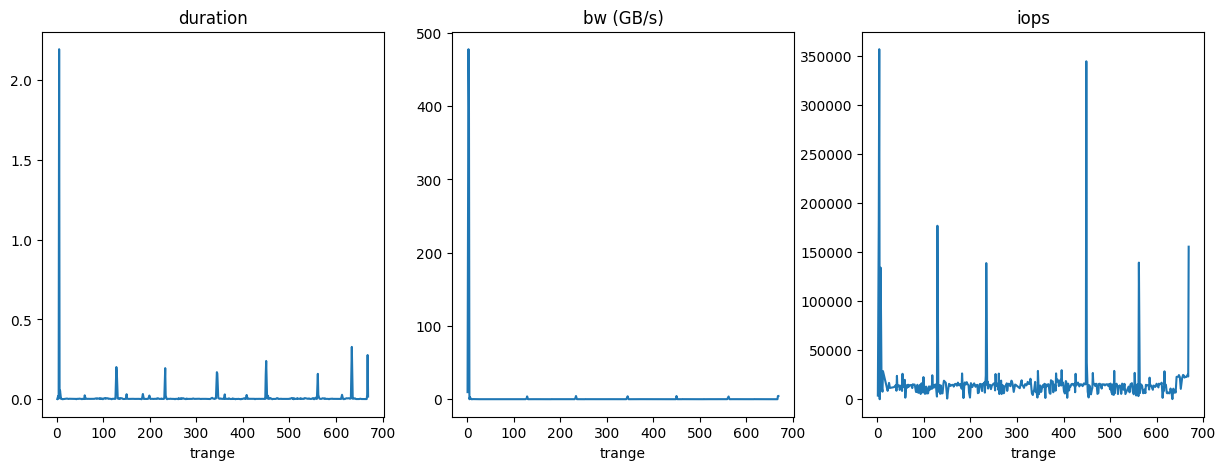

time: 2.3 s (started: 2023-06-20 10:20:40 -07:00)


In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

trange_dur_view['duration_sum'].plot.line(ax=axes[0], title='duration')
trange_bw_view['bw'].apply(lambda x: x / 1024 ** 3).plot.line(ax=axes[1], title='bw (GB/s)')
trange_iops_view['iops'].plot.line(ax=axes[2], title='iops')

This BW and IOPS should be translated as 'the maximum BW/IOPS a process has achieved within given trange' -- similar to 'I/O time', in which we find the maximum duration a process within a given trange/file_name achieves

## Trange Views

In [36]:
trange_views = {
    'duration': compute_view(main_view, 'trange', 'duration_sum', max_io_time, DELTA),
    'bw': compute_view(main_view, 'trange', 'bw', None, DELTA * 10, True),
    'iops': compute_view(main_view, 'trange', 'iops', None, DELTA * 1000, True),
}

time: 212 ms (started: 2023-06-20 10:20:45 -07:00)


In [37]:
trange_views['duration'].compute()

duration_sum  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024       0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024       0.001609   
3      /dev/null                                          app1#localhost#1#35184372411024        0.000003   
                                                          app1#localhost#10#35184372411024       0.000002   
                                                          app1#localhost#100#35184372411024      0.000003   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024      0.000005   
                                                          app1#localhost#880#35184372411024      0.000005   
                                                          app1#localhost#920#35184372411024      0.000005   
                                                          app1#localhost#960#35184372411024      0.000005   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000226   

                                                                                             index_count  \
trange file_name                                          proc_name                                        
1      /dev/null                                          app1#localhost#17#35184372411024             1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024             5   
3      /dev/null                                          app1#localhost#1#35184372411024              1   
                                                          app1#localhost#10#35184372411024             1   
                                                          app1#localhost#100#35184372411024            1   
...                                                                                                  ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024            1   
                                                          app1#localhost#880#35184372411024            1   
                                                          app1#localhost#920#35184372411024            1   
                                                          app1#localhost#960#35184372411024            1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              2   

                                                                                             size_min  \
trange file_name                                          proc_name                                     
1      /dev/null                                          app1#localhost#17#35184372411024          0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /dev/null                                          app1#localhost#1#35184372411024           0   
                                                          app1#localhost#10#35184372411024          0   
                                                          app1#localhost#100#35184372411024         0   
...                                                                                               ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024         0   
                                                          app1#localhost#880#35184372411024         0   
                                                          app1#localhost#920#35184372411024         0   
                                                          app1#localhost#960#35184372411024         0   
       /p/

time: 278 ms (started: 2023-06-20 10:20:46 -07:00)


In [38]:
trange_views['bw'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024      2.151723   
                                                          app1#localhost#1040#35184372411024      1.952563   
                                                          app1#localhost#1080#35184372411024      2.116145   
                                                          app1#localhost#1120#35184372411024      2.116290   
                                                          app1#localhost#1160#35184372411024      2.026798   
...                                                                                                    ...   
667    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#960#35184372411024       0.000148   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000179   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000061   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000382   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000041   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1040#35184372411024            1   
                                                          app1#localhost#1080#35184372411024            1   
                                                          app1#localhost#1120#35184372411024            1   
                                                          app1#localhost#1160#35184372411024            1   
...                                                                                                   ...   
667    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#960#35184372411024             3   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1040#35184372411024         0   
                                                          app1#localhost#1080#35184372411024         0   
                                                          app1#localhost#1120#35184372411024         0   
                                                          app1#localhost#1160#35184372411024         0   
...                                                                                                ...   
667    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#960#35184372411024          0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024          643   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024          140   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#3518

time: 223 ms (started: 2023-06-20 10:20:47 -07:00)


In [39]:
trange_views['iops'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
1      /dev/null                                          app1#localhost#17#35184372411024        0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024        0.001609   
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024      2.151723   
                                                          app1#localhost#1040#35184372411024      1.952563   
                                                          app1#localhost#1080#35184372411024      2.116145   
...                                                                                                    ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024       0.000170   
                                                          app1#localhost#880#35184372411024       0.000115   
                                                          app1#localhost#920#35184372411024       0.000139   
                                                          app1#localhost#960#35184372411024       0.000147   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000311   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024              1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024              5   
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1040#35184372411024            1   
                                                          app1#localhost#1080#35184372411024            1   
...                                                                                                   ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024             3   
                                                          app1#localhost#880#35184372411024             3   
                                                          app1#localhost#920#35184372411024             3   
                                                          app1#localhost#960#35184372411024             3   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               6   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024           0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024    16777216   
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1040#35184372411024         0   
                                                          app1#localhost#1080#35184372411024         0   
...                                                                                                ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024          0   
                                                          app1#localhost#880#35184372411024          0   
                                                          app1#localhost#920#35184372411024          0   
                                                          app1#localhost#960#35

time: 212 ms (started: 2023-06-20 10:20:48 -07:00)


In [40]:
BOTTLENECK_ORDER = dict(
    app_name=('app_name', 'trange', 'file_name'),
    file_dir=('file_dir', 'proc_name', 'trange'),
    file_name=('file_name', 'proc_name', 'trange'),
    file_regex=('file_regex', 'proc_name', 'trange'),
    node_name=('node_name', 'trange', 'file_name'),
    proc_name=('proc_name', 'trange', 'file_name'),
    rank=('rank', 'trange', 'file_name'),
    trange=('trange', 'proc_name', 'file_name'),
)


def set_metric_percentages(df: pd.DataFrame, metric_col: str, metric_max: float):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col
    delta_col, pero_col, perr_col = (
        f"{metric}_delta",
        f"{metric}_pero",
        f"{metric}_perr"
    )
    if metric_col in ['bw', 'iops']:
        df[delta_col] = 1 - df[metric_col] / metric_max
        return df
    df[pero_col] = df[metric_col] / metric_max
    df[perr_col] = df[metric_col] / df[metric_col].sum()
    return df


def set_metric_scores(df: pd.DataFrame, metric_col: str, col: str, is_reversed=False):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col
    bin_col, score_col, threshold_col = (
        f"{metric}_bin",
        f"{metric}_score",
        f"{metric}_th",
    )
    # bin_names = np.flip(DELTA_BIN_NAMES) if is_reversed else DELTA_BIN_NAMES
    # df[bin_col] = np.digitize(1 - df[col] if is_reversed else df[col], bins=DELTA_BINS, right=True)
    df[bin_col] = np.digitize(df[col], bins=DELTA_BINS, right=True)
    df[score_col] = np.choose(df[bin_col] - 1, choices=DELTA_BIN_NAMES, mode='clip')
    df[threshold_col] = np.choose(df[bin_col] - 1, choices=DELTA_BINS, mode='clip')
    return df.drop(columns=[bin_col])


def generate_bottlenecks_views(
    view_type: str,
    view: dd.DataFrame,
    metric_col: str,
    metric_max: dd.core.Scalar,
    is_reversed=False
):
    metric = metric_col.replace('_sum', '') if '_sum' in metric_col else metric_col

    # Create lower level view
    low_level_view = view \
        .groupby(list(BOTTLENECK_ORDER[view_type])) \
        .first()

    # Non-proc agg columns
    non_proc_agg_dict = _get_agg_dict(view_columns=low_level_view.columns, is_proc=False)
    proc_agg_dict = _get_agg_dict(view_columns=low_level_view.columns, is_proc=True)

    # Create mid and high level views
    if view_type is not PROC_COL:
        mid_level_view = low_level_view \
            .reset_index() \
            .groupby([view_type, PROC_COL]) \
            .agg(non_proc_agg_dict)

        high_level_view = mid_level_view \
            .reset_index() \
            .groupby([view_type]) \
            .agg(proc_agg_dict)
    else:
        mid_level_view = low_level_view \
            .reset_index() \
            .groupby([view_type, TRANGE_COL]) \
            .agg(non_proc_agg_dict)

        high_level_view = mid_level_view \
            .reset_index() \
            .groupby([view_type]) \
            .agg(non_proc_agg_dict)
        
    if metric_max is None:
        metric_max = high_level_view[metric_col].max()

    col = f"{metric}_pero"
    if metric_col in ['bw', 'iops']:
        col = f"{metric}_delta"

    low_level_view = low_level_view \
        .map_partitions(set_metrics) \
        .map_partitions(set_metric_percentages, metric_col=metric_col, metric_max=metric_max) \
        .map_partitions(set_metric_scores, metric_col=metric_col, col=col, is_reversed=is_reversed)

    mid_level_view = mid_level_view \
        .map_partitions(set_metrics) \
        .map_partitions(set_metric_percentages, metric_col=metric_col, metric_max=metric_max) \
        .map_partitions(set_metric_scores, metric_col=metric_col, col=col, is_reversed=is_reversed)

    high_level_view = high_level_view \
        .map_partitions(set_metrics) \
        .map_partitions(set_metric_percentages, metric_col=metric_col, metric_max=metric_max) \
        .map_partitions(set_metric_scores, metric_col=metric_col, col=col, is_reversed=is_reversed)

    return dict(
        low_level_view=low_level_view,
        mid_level_view=mid_level_view,
        high_level_view=high_level_view,
    )


def _get_agg_dict(view_columns: list, is_proc=False):
    if is_proc:
        agg_dict = {col: max if any(x in col for x in 'duration time'.split()) else sum for col in view_columns}
    else:
        agg_dict = {col: sum for col in view_columns}
    agg_dict['size_min'] = min
    agg_dict['size_max'] = max
    for view_type in [*VIEW_TYPES, *LOGICAL_VIEW_TYPES]:
        if view_type in agg_dict:
            agg_dict.pop(view_type)
    return agg_dict

time: 6.95 ms (started: 2023-06-20 10:20:49 -07:00)


In [41]:
trange_dur_bott = generate_bottlenecks_views(
    view_type='trange',
    view=trange_views['duration'],
    metric_col='duration_sum',
    metric_max=max_io_time
)
trange_dur_bott_ll = trange_dur_bott['high_level_view'].compute()
trange_dur_bott_ll

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,bw,iops,intensity,id,bw_intensity,att_perf,duration_pero,duration_perr,duration_score,duration_th
trange,,,,,,,,,,,,,,,,,,,,,
1,0.001612,6,0,16777216,16777216,0.001470,0.000000,0.000142,16777216,0,...,1.040899e+10,3722.546191,3.576279e-07,-7.770690e+18,6.803647e+02,6.803647e+02,0.000392,0.000275,none,0.000
3,0.020756,7673,0,16777216,21441282048,0.001981,0.000000,0.020747,21441282048,0,...,1.033036e+12,369683.347498,3.578611e-07,-1.351802e+20,1.655172e+11,1.953726e+09,0.005044,0.003545,trivial,0.001
4,0.004128,58,0,16777216,50456557,0.001317,0.000201,0.002610,50331648,124909,...,1.222448e+10,14052.089326,1.149504e-06,1.714914e+19,1.787146e+09,1.357908e+07,0.001003,0.000705,trivial,0.001
5,2.191843,32,0,0,0,0.000000,0.000000,2.191843,0,0,...,0.000000e+00,14.599587,0.000000e+00,-2.436862e+19,0.000000e+00,0.000000e+00,0.532634,0.374355,high,0.500
6,0.011320,384,0,16777216,33560897,0.000000,0.006047,0.005273,0,33560897,...,2.964770e+09,33922.561157,1.144189e-05,1.202371e+20,3.247910e+08,8.985663e+07,0.002751,0.001933,trivial,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.001761,40,5530,97648,227631,0.000000,0.000411,0.001350,0,130255,...,1.292477e+08,22711.787246,1.757230e-04,-1.417959e+19,2.148198e+08,7.917566e+06,0.000428,0.000301,none,0.000
666,0.001675,40,5530,97920,227903,0.000000,0.000377,0.001298,0,130255,...,1.360777e+08,23883.448781,1.755133e-04,-1.186805e+19,4.468558e+08,8.079364e+06,0.000407,0.000286,none,0.000
667,0.027776,142,0,98192,104505,0.000000,0.000191,0.027585,0,6465,...,3.762461e+06,5112.382342,1.358787e-03,1.260081e+19,3.295203e+09,3.039387e+07,0.006750,0.004744,trivial,0.001


time: 739 ms (started: 2023-06-20 10:20:50 -07:00)


In [63]:
DELTA_BINS

[0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9]

time: 4.21 ms (started: 2023-06-20 10:33:30 -07:00)


<Axes: title={'center': 'duration_sum'}, xlabel='trange', ylabel='duration_sum'>

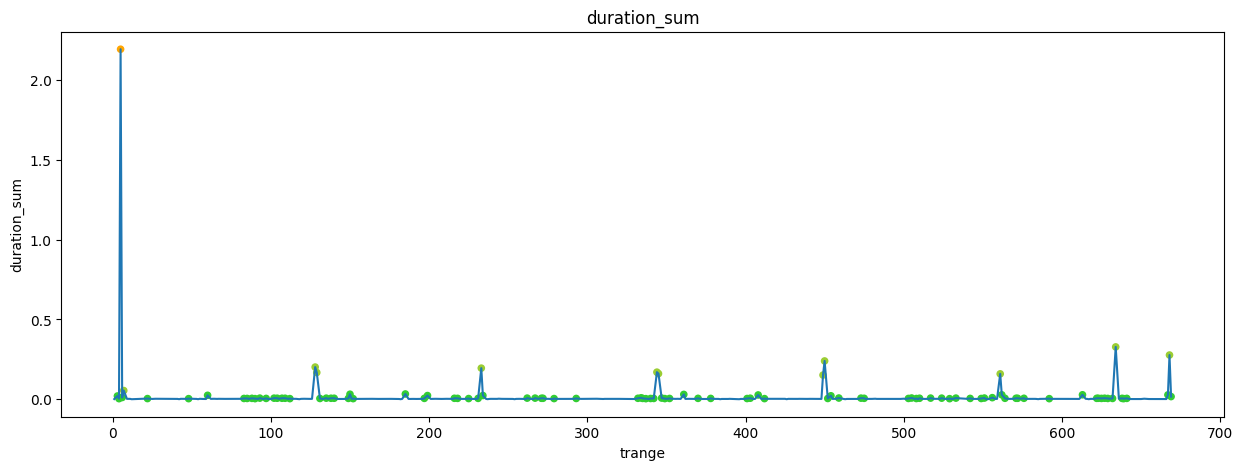

time: 430 ms (started: 2023-06-20 10:37:53 -07:00)


In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define the colormap
cmap = plt.cm.get_cmap('RdYlGn')  # Green to Yellow to Red colormap

# Create a function to map 'duration_th' values to colors
def map_color(duration_th):
    if duration_th >= 0.9:
        return 'red'
    elif duration_th >= 0.75:
        return 'darkorange'
    elif duration_th >= 0.5:
        return 'orange'
    elif duration_th >= 0.25:
        return 'gold'
    elif duration_th >= 0.1:
        return 'yellow'
    elif duration_th >= 0.01:
        return 'yellowgreen'
    elif duration_th >= 0.001:
        return 'limegreen'
    else:
        return 'green'

# Plot the scatter plot with fixed colormap
trange_dur_ax = trange_dur_view['duration_sum'].plot(title='duration_sum', figsize=(15, 5))
trange_dur_data = trange_dur_bott_ll.query('duration_th > 0').reset_index()
trange_dur_colors = np.vectorize(map_color)(trange_dur_data['duration_th'])
trange_dur_data.plot.scatter(ax=trange_dur_ax, x='trange', y='duration_sum', c=trange_dur_colors, cmap=cmap)


<Axes: title={'center': 'duration_sum'}, xlabel='trange', ylabel='duration_sum'>

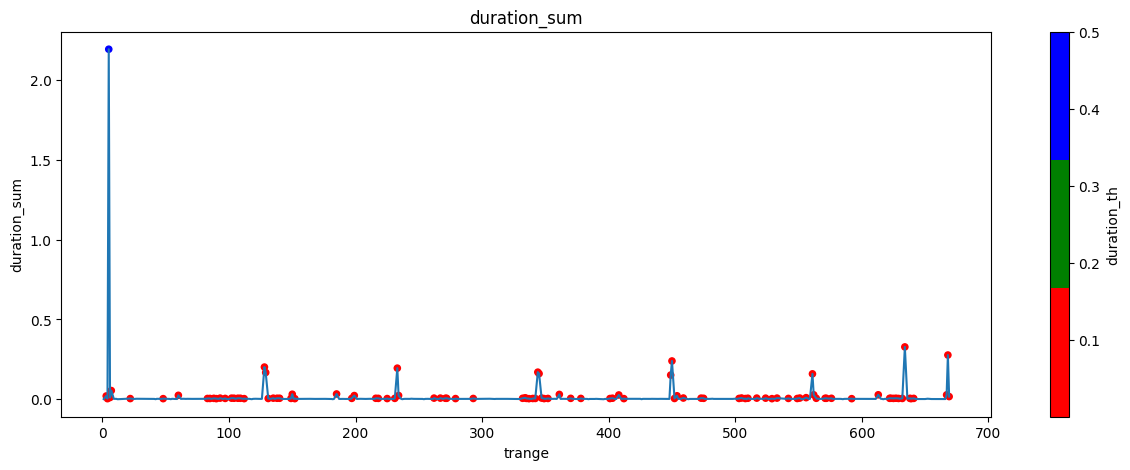

time: 827 ms (started: 2023-06-20 10:27:56 -07:00)


In [53]:
trange_dur_ax = trange_dur_view['duration_sum'].plot(title='duration_sum', figsize=(15, 5))
trange_dur_bott_ll \
    .query('duration_th > 0') \
    .reset_index() \
    .plot.scatter(ax=trange_dur_ax, x='trange', y='duration_sum', c='duration_th', cmap=cmap)

In [321]:
trange_bw_bott = generate_bottlenecks_views(
    view_type='trange',
    view=trange_views['bw'],
    metric_col='bw',
    metric_max=None,
    is_reversed=True
)
trange_bw_bott_ll = trange_bw_bott['high_level_view'].compute()
trange_bw_bott_ll

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,bw_intensity,att_perf,bw_delta,bw_score,bw_th
trange,,,,,,,,,,,,,,,,,,,,,
5,2.191843,32,0,0,0,0.0,0.000000,2.191843,0,0,...,0,0,0.000000e+00,14.599587,0.000000,0.000000e+00,0.000000e+00,1.000000,critical,0.9
9,0.003103,40,544,49340,130527,0.0,0.000421,0.002682,0,130255,...,5,14,4.206884e+07,12891.997337,0.000306,1.378460e+07,8.203840e+06,0.999619,critical,0.9
11,0.002862,22,0,5530,6346,0.0,0.000114,0.002748,0,5802,...,3,10,2.217331e+06,7686.932308,0.003467,2.043102e+06,2.043102e+06,0.999980,critical,0.9
12,0.000628,18,13785,49340,124453,0.0,0.000273,0.000355,0,124453,...,2,4,1.981420e+08,28657.857004,0.000145,3.278121e+05,3.278121e+05,0.998203,critical,0.9
22,0.004685,40,1088,49340,131071,0.0,0.000848,0.003837,0,130255,...,5,14,2.797554e+07,8537.522333,0.000305,1.283419e+07,7.946086e+06,0.999746,critical,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0.001810,40,5530,97104,227087,0.0,0.000394,0.001416,0,130255,...,5,14,1.254832e+08,22103.110769,0.000176,1.940718e+08,7.516367e+06,0.998862,critical,0.9
662,0.001751,40,5530,97376,227359,0.0,0.000380,0.001371,0,130255,...,5,14,1.298526e+08,22845.393962,0.000176,1.951350e+08,9.337559e+06,0.998823,critical,0.9
664,0.001761,40,5530,97648,227631,0.0,0.000411,0.001350,0,130255,...,5,14,1.292477e+08,22711.787246,0.000176,2.148198e+08,7.917566e+06,0.998828,critical,0.9


time: 689 ms (started: 2023-06-14 16:25:08 -07:00)


<Axes: title={'center': 'bw'}, xlabel='trange', ylabel='bw'>

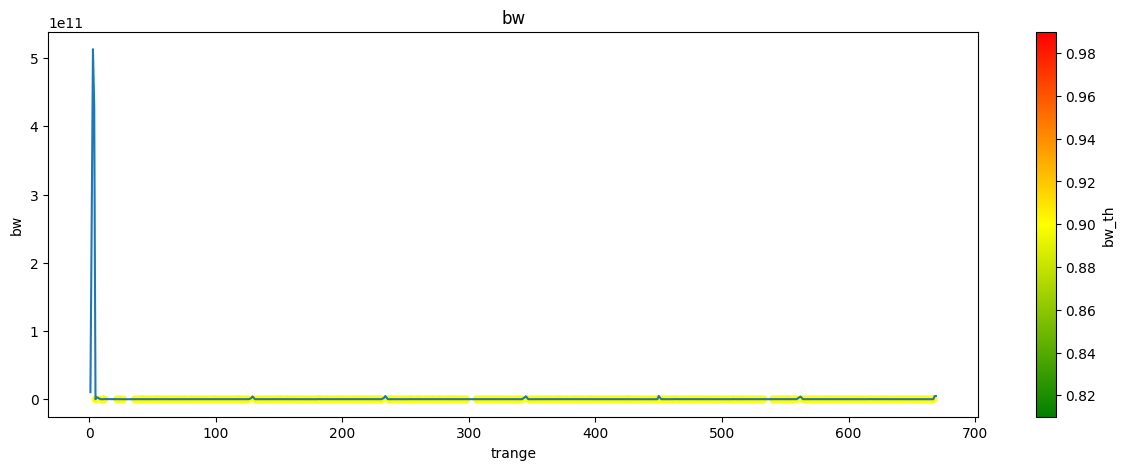

time: 672 ms (started: 2023-06-14 16:25:09 -07:00)


In [322]:
import matplotlib.pyplot as plt
import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

trange_bw_ax = trange_bw_view['bw'].plot(title='bw', figsize=(15, 5))

trange_bw_bott_ll \
    .query('bw_th > 0') \
    .reset_index() \
    .plot.scatter(ax=trange_bw_ax, x='trange', y='bw', c='bw_th', cmap=cmap)

In [323]:
trange_iops_bott = generate_bottlenecks_views(
    view_type='trange',
    view=trange_views['iops'],
    metric_col='iops',
    metric_max=None,
    is_reversed=True
)
trange_iops_bott_ll = trange_iops_bott['high_level_view'].compute()
trange_iops_bott_ll

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,bw_intensity,att_perf,iops_delta,iops_score,iops_th
trange,,,,,,,,,,,,,,,,,,,,,
1,0.001612,6,0,16777216,16777216,0.00147,0.000000,0.000142,16777216,0,...,0,3,1.040899e+10,3722.546191,3.576279e-07,6.803647e+02,6.803647e+02,0.999982,critical,0.9
5,2.191843,32,0,0,0,0.00000,0.000000,2.191843,0,0,...,0,0,0.000000e+00,14.599587,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,critical,0.9
6,0.011320,384,0,16777216,33560897,0.00000,0.006047,0.005273,0,33560897,...,2,270,2.964770e+09,33922.561157,1.144189e-05,3.247910e+08,8.985663e+07,0.999839,critical,0.9
9,0.003103,40,544,49340,130527,0.00000,0.000421,0.002682,0,130255,...,5,14,4.206884e+07,12891.997337,3.064500e-04,1.378460e+07,8.203840e+06,0.999939,critical,0.9
11,0.002862,22,0,5530,6346,0.00000,0.000114,0.002748,0,5802,...,3,10,2.217331e+06,7686.932308,3.466751e-03,2.043102e+06,2.043102e+06,0.999963,critical,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,0.001751,40,5530,97376,227359,0.00000,0.000380,0.001371,0,130255,...,5,14,1.298526e+08,22845.393962,1.759332e-04,1.951350e+08,9.337559e+06,0.999891,critical,0.9
664,0.001761,40,5530,97648,227631,0.00000,0.000411,0.001350,0,130255,...,5,14,1.292477e+08,22711.787246,1.757230e-04,2.148198e+08,7.917566e+06,0.999892,critical,0.9
666,0.001675,40,5530,97920,227903,0.00000,0.000377,0.001298,0,130255,...,5,14,1.360777e+08,23883.448781,1.755133e-04,4.468558e+08,8.079364e+06,0.999887,critical,0.9


time: 696 ms (started: 2023-06-14 16:25:14 -07:00)


<Axes: title={'center': 'iops'}, xlabel='trange', ylabel='iops'>

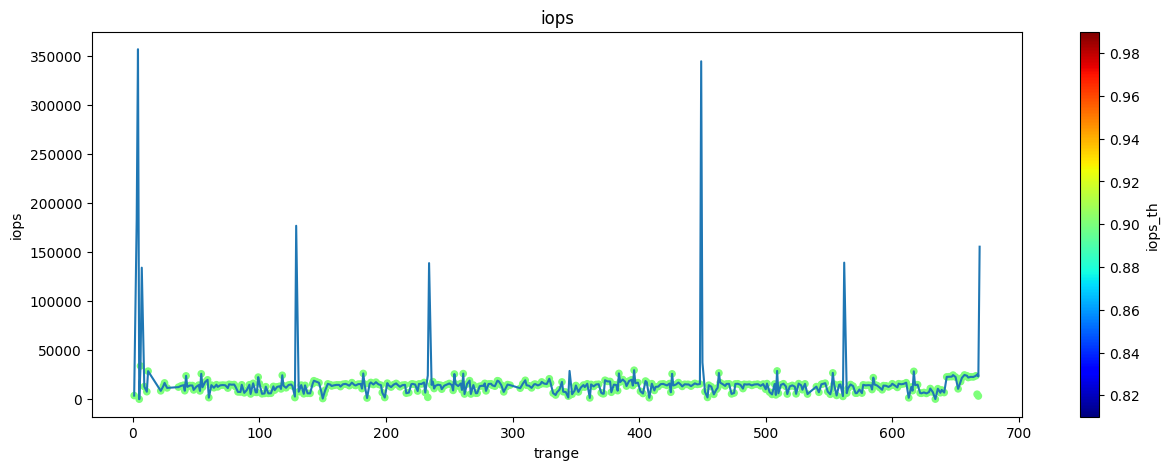

time: 716 ms (started: 2023-06-14 16:25:15 -07:00)


In [324]:
trange_iops_ax = trange_iops_view['iops'].plot(title='iops', figsize=(15, 5))
trange_iops_bott_ll \
    .query('iops_th > 0') \
    .reset_index() \
    .plot.scatter(ax=trange_iops_ax, x='trange', y='iops', c='iops_th', colormap='jet')

In [327]:
import itertools as it

list(it.combinations(['file_name', 'proc_name', 'io_cat', 'acc_pat'], r=2))

[('file_name', 'proc_name'),
 ('file_name', 'io_cat'),
 ('file_name', 'acc_pat'),
 ('proc_name', 'io_cat'),
 ('proc_name', 'acc_pat'),
 ('io_cat', 'acc_pat')]

time: 5.49 ms (started: 2023-06-14 16:52:06 -07:00)


In [335]:
import resource

rsrc = resource.RLIMIT_DATA
soft, hard = resource.getrlimit(rsrc)
print('Soft limit starts as  :', soft)

resource.setrlimit(rsrc, (1024 ** 3, hard)) #limit to one kilobyte

soft, hard = resource.getrlimit(rsrc)
print('Soft limit changed to :', soft)


Soft limit starts as  : -1
Soft limit changed to : 1073741824
time: 1.79 ms (started: 2023-06-14 17:09:39 -07:00)


In [150]:
pd.merge(pd.merge(trange_dur_bott_ll, trange_bw_bott_ll, how='outer', suffixes=None), trange_iops_bott_ll, how='outer', suffixes=None)

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
0,0.000003,1,0,0,0,0.000000,0.0,0.000003,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001609,5,16777216,16777216,16777216,0.001470,0.0,0.000139,16777216,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000034,5,16777216,16777216,16777216,0.000009,0.0,0.000025,16777216,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.020722,6,0,0,0,0.000000,0.0,0.020722,0,0,...,trivial,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000003,1,0,0,0,0.000000,0.0,0.000003,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6721,0.000005,1,0,0,0,0.000000,0.0,0.000005,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6722,0.000033,1,0,0,0,0.000000,0.0,0.000033,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6723,0.000005,1,0,0,0,0.000000,0.0,0.000005,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6724,0.000004,1,0,0,0,0.000000,0.0,0.000004,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 133 ms (started: 2023-06-13 20:04:35 -07:00)


In [151]:
pd.merge(pd.merge(trange_dur_bott_ll, trange_bw_bott_ll, suffixes=None), trange_iops_bott_ll, suffixes=None)

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
0,1.970968,1,0,0,0,0.0,0.000000,1.970968,0,0,...,medium,0.25,0.000000,0.000000e+00,very high,0.75,7.326587e-08,0.000002,very high,0.75
1,2.151723,1,0,0,0,0.0,0.000000,2.151723,0,0,...,high,0.50,0.000000,0.000000e+00,very high,0.75,6.711119e-08,0.000002,very high,0.75
2,1.952563,1,0,0,0,0.0,0.000000,1.952563,0,0,...,medium,0.25,0.000000,0.000000e+00,very high,0.75,7.395649e-08,0.000002,very high,0.75
3,2.116145,1,0,0,0,0.0,0.000000,2.116145,0,0,...,high,0.50,0.000000,0.000000e+00,very high,0.75,6.823951e-08,0.000002,very high,0.75
4,2.116290,1,0,0,0,0.0,0.000000,2.116290,0,0,...,high,0.50,0.000000,0.000000e+00,very high,0.75,6.823483e-08,0.000002,very high,0.75
5,2.026798,1,0,0,0,0.0,0.000000,2.026798,0,0,...,medium,0.25,0.000000,0.000000e+00,very high,0.75,7.124770e-08,0.000002,very high,0.75
6,2.129455,1,0,0,0,0.0,0.000000,2.129455,0,0,...,high,0.50,0.000000,0.000000e+00,very high,0.75,6.781298e-08,0.000002,very high,0.75
7,2.025340,1,0,0,0,0.0,0.000000,2.025340,0,0,...,medium,0.25,0.000000,0.000000e+00,very high,0.75,7.129899e-08,0.000002,very high,0.75
8,2.151049,1,0,0,0,0.0,0.000000,2.151049,0,0,...,high,0.50,0.000000,0.000000e+00,very high,0.75,6.713222e-08,0.000002,very high,0.75
9,2.069059,1,0,0,0,0.0,0.000000,2.069059,0,0,...,high,0.50,0.000000,0.000000e+00,very high,0.75,6.979245e-08,0.000002,very high,0.75


time: 129 ms (started: 2023-06-13 20:04:36 -07:00)


## Proc_name Views

In [45]:
proc_name_views = {
    'duration_sum': compute_view(main_view, 'proc_name', 'duration_sum', max_io_time, DELTA),
    'bw': compute_view(main_view, 'proc_name', 'bw', max_bw, DELTA, True),
    'iops': compute_view(main_view, 'proc_name', 'iops', max_iops, DELTA, True),
}

time: 150 ms (started: 2023-06-05 14:08:58 -07:00)


In [46]:
proc_name_views['duration_sum'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
1      /dev/null                                          app1#localhost#17#35184372411024        0.000003   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024        0.001609   
3      /dev/null                                          app1#localhost#1000#35184372411024      0.000003   
                                                          app1#localhost#1038#35184372411024      0.000003   
                                                          app1#localhost#1040#35184372411024      0.000003   
...                                                                                                    ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024       0.000005   
                                                          app1#localhost#880#35184372411024       0.000005   
                                                          app1#localhost#920#35184372411024       0.000005   
                                                          app1#localhost#960#35184372411024       0.000005   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000226   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024              1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024              5   
3      /dev/null                                          app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1038#35184372411024            1   
                                                          app1#localhost#1040#35184372411024            1   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024             1   
                                                          app1#localhost#880#35184372411024             1   
                                                          app1#localhost#920#35184372411024             1   
                                                          app1#localhost#960#35184372411024             1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               2   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024           0   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024    16777216   
3      /dev/null                                          app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1038#35184372411024         0   
                                                          app1#localhost#1040#35184372411024         0   
...                                                                                                ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024          0   
                                                          app1#localhost#880#35184372411024          0   
                                                          app1#localhost#920#35184372411024          0   
                                                          app1#localhost#960#35

time: 196 ms (started: 2023-06-05 14:08:58 -07:00)


In [47]:
proc_name_views['bw'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
3      /dev/null                                          app1#localhost#1000#35184372411024      0.000003   
                                                          app1#localhost#1040#35184372411024      0.000003   
                                                          app1#localhost#1080#35184372411024      0.000002   
                                                          app1#localhost#1120#35184372411024      0.000003   
                                                          app1#localhost#1160#35184372411024      0.000003   
...                                                                                                    ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#800#35184372411024       0.000005   
                                                          app1#localhost#840#35184372411024       0.000005   
                                                          app1#localhost#880#35184372411024       0.000005   
                                                          app1#localhost#920#35184372411024       0.000005   
                                                          app1#localhost#960#35184372411024       0.000005   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
3      /dev/null                                          app1#localhost#1000#35184372411024            1   
                                                          app1#localhost#1040#35184372411024            1   
                                                          app1#localhost#1080#35184372411024            1   
                                                          app1#localhost#1120#35184372411024            1   
                                                          app1#localhost#1160#35184372411024            1   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#800#35184372411024             1   
                                                          app1#localhost#840#35184372411024             1   
                                                          app1#localhost#880#35184372411024             1   
                                                          app1#localhost#920#35184372411024             1   
                                                          app1#localhost#960#35184372411024             1   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
3      /dev/null                                          app1#localhost#1000#35184372411024         0   
                                                          app1#localhost#1040#35184372411024         0   
                                                          app1#localhost#1080#35184372411024         0   
                                                          app1#localhost#1120#35184372411024         0   
                                                          app1#localhost#1160#35184372411024         0   
...                                                                                                ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#800#35184372411024          0   
                                                          app1#localhost#840#35184372411024          0   
                                                          app1#localhost#880#35184372411024          0   
                                                          app1#localhost#920#35

time: 262 ms (started: 2023-06-05 14:08:59 -07:00)


In [48]:
proc_name_views['iops'].compute()

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity,id
trange,file_name,proc_name,,,,,,,,,,,,,,,,,,,,,


time: 196 ms (started: 2023-06-05 14:08:59 -07:00)


In [49]:
proc_name_botts = {}
for t in proc_name_views:
    proc_name_botts[t] = generate_bottlenecks_views(
        view_type='proc_name',
        view=proc_name_views[t],
        metric_col=t,
        metric_max=max_io_time if t == 'duration_sum' else max_bw if t == 'bw' else max_iops,
        is_reversed=t != 'duration_sum'
    )

time: 1.39 s (started: 2023-06-05 14:08:59 -07:00)


In [50]:
proc_name_dur_bot_ll = proc_name_botts['duration_sum']['low_level_view'].compute()
proc_name_dur_bot_ll

duration_sum  \
proc_name                         trange file_name                                                          
app1#localhost#0#35184372411024   3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000034   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.020722   
                                  4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.001437   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.002457   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000003   
...                                                                                                   ...   
app1#localhost#960#35184372411024 668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000147   
                                  669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000033   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000004   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   

                                                                                             index_count  \
proc_name                         trange file_name                                                         
app1#localhost#0#35184372411024   3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            6   
                                  4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            8   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
...                                                                                                  ...   
app1#localhost#960#35184372411024 668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            3   
                                  669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   

                                                                                             size_min  \
proc_name                         trange file_name                                                      
app1#localhost#0#35184372411024   3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                  4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      2055   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
...                                                                                               ...   
app1#localhost#960#35184372411024 668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                  669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                         /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
          

time: 310 ms (started: 2023-06-05 14:09:01 -07:00)


In [51]:
proc_name_bw_bot_ll = proc_name_botts['bw']['low_level_view'].compute()
proc_name_bw_bot_ll

duration_sum  \
proc_name                          trange file_name                                                          
app1#localhost#1000#35184372411024 3      /dev/null                                               0.000003   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000039   
                                   4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000003   
                                   5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      2.151723   
                                   6      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000003   
...                                                                                                    ...   
app1#localhost#960#35184372411024  668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000147   
                                   669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000033   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000004   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...      0.000005   

                                                                                              index_count  \
proc_name                          trange file_name                                                         
app1#localhost#1000#35184372411024 3      /dev/null                                                     1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            5   
                                   4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                   5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                   6      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            2   
...                                                                                                   ...   
app1#localhost#960#35184372411024  668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            3   
                                   669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...            1   

                                                                                              size_min  \
proc_name                          trange file_name                                                      
app1#localhost#1000#35184372411024 3      /dev/null                                                  0   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...  16777216   
                                   4      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                   5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                   6      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
...                                                                                                ...   
app1#localhost#960#35184372411024  668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                   669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file...         0   
                                          /p/gpfs1/iopp/temp/cm1r20.3.2846827/c

time: 227 ms (started: 2023-06-05 14:09:02 -07:00)


In [52]:
proc_name_iops_bot_ll = proc_name_botts['iops']['low_level_view'].compute()
proc_name_iops_bot_ll

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,id,iops_pero,iops_perr,iops_score,iops_th
proc_name,trange,file_name,,,,,,,,,,,,,,,,,,,,,


time: 215 ms (started: 2023-06-05 14:09:02 -07:00)


## File_name Views

In [53]:
file_name_views = {
    'duration_sum': compute_view(main_view, 'file_name', 'duration_sum', max_io_time, DELTA),
    'bw': compute_view(main_view, 'file_name', 'bw', max_bw, DELTA, True),
    'iops': compute_view(main_view, 'file_name', 'iops', max_iops, DELTA, True),
}

time: 259 ms (started: 2023-06-05 14:09:03 -07:00)


In [54]:
file_name_views['duration_sum'].compute()

duration_sum  \
trange file_name                                          proc_name                                         
1      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024       0.001609   
3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000034   
                                                          app1#localhost#1#35184372411024        0.000037   
                                                          app1#localhost#10#35184372411024       0.000035   
                                                          app1#localhost#100#35184372411024      0.000037   
...                                                                                                   ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024      0.000005   
                                                          app1#localhost#880#35184372411024      0.000005   
                                                          app1#localhost#920#35184372411024      0.000005   
                                                          app1#localhost#960#35184372411024      0.000005   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024        0.000226   

                                                                                             index_count  \
trange file_name                                          proc_name                                        
1      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024             5   
3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              5   
                                                          app1#localhost#1#35184372411024              5   
                                                          app1#localhost#10#35184372411024             5   
                                                          app1#localhost#100#35184372411024            5   
...                                                                                                  ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024            1   
                                                          app1#localhost#880#35184372411024            1   
                                                          app1#localhost#920#35184372411024            1   
                                                          app1#localhost#960#35184372411024            1   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024              2   

                                                                                             size_min  \
trange file_name                                          proc_name                                     
1      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#17#35184372411024   16777216   
3      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    16777216   
                                                          app1#localhost#1#35184372411024    16777216   
                                                          app1#localhost#10#35184372411024   16777216   
                                                          app1#localhost#100#35184372411024  16777216   
...                                                                                               ...   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#840#35184372411024         0   
                                                          app1#localhost#880#35184372411024         0   
                                                          app1#localhost#920#35184372411024         0   
                                                          app1#localhost#960#35184372411024         0   
       /p/

time: 195 ms (started: 2023-06-05 14:09:03 -07:00)


In [55]:
file_name_views['bw'].compute()

duration_sum  \
trange file_name                                          proc_name                                          
1      /dev/null                                          app1#localhost#17#35184372411024        0.000003   
3      /dev/null                                          app1#localhost#1#35184372411024         0.000003   
                                                          app1#localhost#10#35184372411024        0.000002   
                                                          app1#localhost#100#35184372411024       0.000003   
                                                          app1#localhost#1000#35184372411024      0.000003   
...                                                                                                    ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000140   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000134   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000141   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000311   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         0.000226   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
1      /dev/null                                          app1#localhost#17#35184372411024              1   
3      /dev/null                                          app1#localhost#1#35184372411024               1   
                                                          app1#localhost#10#35184372411024              1   
                                                          app1#localhost#100#35184372411024             1   
                                                          app1#localhost#1000#35184372411024            1   
...                                                                                                   ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               7   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               6   
669    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024               2   

                                                                                              size_min  \
trange file_name                                          proc_name                                      
1      /dev/null                                          app1#localhost#17#35184372411024           0   
3      /dev/null                                          app1#localhost#1#35184372411024            0   
                                                          app1#localhost#10#35184372411024           0   
                                                          app1#localhost#100#35184372411024          0   
                                                          app1#localhost#1000#35184372411024         0   
...                                                                                                ...   
668    /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         2602   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         2602   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         3491   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#3518

time: 187 ms (started: 2023-06-05 14:09:03 -07:00)


In [56]:
file_name_views['iops'].compute()

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity,id
trange,file_name,proc_name,,,,,,,,,,,,,,,,,,,,,


time: 170 ms (started: 2023-06-05 14:09:04 -07:00)


In [57]:
file_name_botts = {}
for t in file_name_views:
    file_name_botts[t] = generate_bottlenecks_views(
        view_type='file_name',
        view=file_name_views[t],
        metric_col=t,
        metric_max=max_io_time if t == 'duration_sum' else max_bw if t == 'bw' else max_iops,
        is_reversed=t != 'duration_sum'
    )

time: 833 ms (started: 2023-06-05 14:09:04 -07:00)


In [58]:
file_name_dur_bot_ll = file_name_botts['duration_sum']['low_level_view'].compute()
file_name_dur_bot_ll

duration_sum  \
file_name                                          proc_name                          trange                 
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           0.001437   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           0.002457   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6           0.005920   
                                                                                      7           0.001533   
                                                   app1#localhost#1000#35184372411024 4           0.000003   
...                                                                                                    ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3           0.000036   
                                                   app1#localhost#998#35184372411024  3           0.000037   
                                                   app1#localhost#999#35184372411024  3           0.000035   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3           0.020722   
                                                                                      4           0.000192   

                                                                                              index_count  \
file_name                                          proc_name                          trange                
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4                 5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4                 8   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6                 5   
                                                                                      7                 2   
                                                   app1#localhost#1000#35184372411024 4                 1   
...                                                                                                   ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3                 5   
                                                   app1#localhost#998#35184372411024  3                 5   
                                                   app1#localhost#999#35184372411024  3                 5   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3                 6   
                                                                                      4                 2   

                                                                                              size_min  \
file_name                                          proc_name                          trange             
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4       16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    4           2055   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    6       16777216   
                                                                                      7       11010048   
                                                   app1#localhost#1000#35184372411024 4              0   
...                                                                                                ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#997#35184372411024  3       16777216   
                                                   app1#localhost#998#35184372411024  3       16777216   
                                                   app1#localhost#999#35184372411024  3       16777216   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411

time: 301 ms (started: 2023-06-05 14:09:05 -07:00)


In [59]:
file_name_bw_bot_ll = file_name_botts['bw']['low_level_view'].compute()
file_name_bw_bot_ll

duration_sum  \
file_name                                          proc_name                          trange                 
/dev/null                                          app1#localhost#1#35184372411024    3           0.000003   
                                                   app1#localhost#10#35184372411024   3           0.000002   
                                                   app1#localhost#100#35184372411024  3           0.000003   
                                                   app1#localhost#1000#35184372411024 3           0.000003   
                                                   app1#localhost#1001#35184372411024 3           0.000003   
...                                                                                                    ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    345         0.000904   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    668         0.000311   
                                                                                      669         0.000226   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3           0.020722   
                                                                                      4           0.000192   

                                                                                              index_count  \
file_name                                          proc_name                          trange                
/dev/null                                          app1#localhost#1#35184372411024    3                 1   
                                                   app1#localhost#10#35184372411024   3                 1   
                                                   app1#localhost#100#35184372411024  3                 1   
                                                   app1#localhost#1000#35184372411024 3                 1   
                                                   app1#localhost#1001#35184372411024 3                 1   
...                                                                                                   ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    345               8   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    668               6   
                                                                                      669               2   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    3                 6   
                                                                                      4                 2   

                                                                                              size_min  \
file_name                                          proc_name                          trange             
/dev/null                                          app1#localhost#1#35184372411024    3              0   
                                                   app1#localhost#10#35184372411024   3              0   
                                                   app1#localhost#100#35184372411024  3              0   
                                                   app1#localhost#1000#35184372411024 3              0   
                                                   app1#localhost#1001#35184372411024 3              0   
...                                                                                                ...   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    345         6112   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024    668            0   
                                                                                      669         6112   
/p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411

time: 337 ms (started: 2023-06-05 14:09:05 -07:00)


In [60]:
file_name_iops_bot_ll = file_name_botts['iops']['low_level_view'].compute()
file_name_iops_bot_ll

,,,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,seek_count,stat_count,bw,iops,intensity,id,iops_pero,iops_perr,iops_score,iops_th
file_name,proc_name,trange,,,,,,,,,,,,,,,,,,,,,


time: 382 ms (started: 2023-06-05 14:09:06 -07:00)


## Analysis

In [61]:
bott_merged = pd.concat([
    trange_dur_bott_ll,
    trange_bw_bott_ll,
    trange_iops_bott_ll,
    proc_name_dur_bot_ll,
    proc_name_bw_bot_ll,
    proc_name_iops_bot_ll,
    file_name_dur_bot_ll,
    file_name_bw_bot_ll,
    file_name_iops_bot_ll,
], ignore_index=True)
bott_merged

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
0,0.000003,1,0,0,0,0.000000,0.000000,0.000003,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001609,5,16777216,16777216,16777216,0.001470,0.000000,0.000139,16777216,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000034,5,16777216,16777216,16777216,0.000009,0.000000,0.000025,16777216,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.020722,6,0,0,0,0.000000,0.000000,0.020722,0,0,...,trivial,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000003,1,0,0,0,0.000000,0.000000,0.000003,0,0,...,none,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22003,0.000904,8,6112,6112,6112,0.000000,0.000154,0.000750,0,6112,...,NaN,NaN,0.000013,0.000100,very high,0.75,NaN,NaN,NaN,NaN
22004,0.000311,6,0,0,0,0.000000,0.000000,0.000311,0,0,...,NaN,NaN,0.000000,0.000000,very high,0.75,NaN,NaN,NaN,NaN
22005,0.000226,2,6112,6112,6112,0.000000,0.000153,0.000073,0,6112,...,NaN,NaN,0.000053,0.000398,very high,0.75,NaN,NaN,NaN,NaN
22006,0.020722,6,0,0,0,0.000000,0.000000,0.020722,0,0,...,NaN,NaN,0.000000,0.000000,very high,0.75,NaN,NaN,NaN,NaN


time: 133 ms (started: 2023-06-05 14:09:07 -07:00)


In [62]:
recurring_ids = bott_merged['id'].value_counts()
recurring_ids

 8159149759523871790    6
-3580648880550333853    6
 2049833725897262901    6
-8750083313744262995    6
 1319174540603289259    6
                       ..
 6299769423444245045    2
-6589248155319838959    2
-8135257349364404327    2
 6202131317584764575    2
-2907254756546469629    2
Name: id, Length: 6726, dtype: int64

time: 8.13 ms (started: 2023-06-05 14:09:08 -07:00)


<Axes: ylabel='id'>

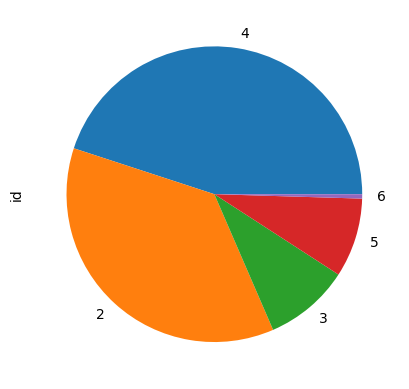

time: 187 ms (started: 2023-06-05 14:09:08 -07:00)


In [63]:
recurring_ids.value_counts().plot.pie()

In [64]:
most_recurring_ids = recurring_ids[recurring_ids == 6]
most_recurring_ids

 8159149759523871790    6
-3580648880550333853    6
 2049833725897262901    6
-8750083313744262995    6
 1319174540603289259    6
 9046877151916567929    6
 3551969272465241348    6
-7417298176380334998    6
-2882538150951803522    6
-3246852102937042135    6
 5695934534717213566    6
-5195052300134216569    6
-1342937767561985998    6
 507466036300524020     6
 3294435043668060302    6
 4994763547029287203    6
-939230427729634983     6
 1300398369164823999    6
-2162579097662219064    6
 863074684830707321     6
-6505113466893468195    6
-5925359111880137852    6
-388973643969515740     6
-7372192307012695496    6
 6613042384359419540    6
-5542846963605308636    6
 4384684247706470375    6
-2322742444232083590    6
-8331575384389315226    6
 4854585461981606144    6
-1020569491675474462    6
-8062162919346696497    6
Name: id, dtype: int64

time: 5.7 ms (started: 2023-06-05 14:09:08 -07:00)


In [65]:
most_recurring_ll = bott_merged[bott_merged['id'].isin(most_recurring_ids.index)]
most_recurring_ll

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
2596,1.970968,1,0,0,0,0.0,0.0,1.970968,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2597,2.151723,1,0,0,0,0.0,0.0,2.151723,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2598,1.952563,1,0,0,0,0.0,0.0,1.952563,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2599,2.116145,1,0,0,0,0.0,0.0,2.116145,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2600,2.116290,1,0,0,0,0.0,0.0,2.116290,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13959,2.164203,1,0,0,0,0.0,0.0,2.164203,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13963,2.010935,1,0,0,0,0.0,0.0,2.010935,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13967,2.164720,1,0,0,0,0.0,0.0,2.164720,0,0,...,high,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16859,1.970968,1,0,0,0,0.0,0.0,1.970968,0,0,...,medium,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 47.8 ms (started: 2023-06-05 14:09:08 -07:00)


In [66]:
most_recurring_ll.groupby(['id']).first()

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,...,duration_score,duration_th,bw_pero,bw_perr,bw_score,bw_th,iops_pero,iops_perr,iops_score,iops_th
id,,,,,,,,,,,,,,,,,,,,,
-8750083313744262995,2.054732,1,0,0,0,0.0,0.0,2.054732,0,0,...,medium,0.25,0.0,0.0,very high,0.75,0.000003,0.031690,very high,0.75
-8331575384389315226,2.116145,1,0,0,0,0.0,0.0,2.116145,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030770,very high,0.75
-8062162919346696497,1.970968,1,0,0,0,0.0,0.0,1.970968,0,0,...,medium,0.25,0.0,0.0,very high,0.75,0.000003,0.033036,very high,0.75
-7417298176380334998,2.164277,1,0,0,0,0.0,0.0,2.164277,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030086,very high,0.75
-7372192307012695496,2.151049,1,0,0,0,0.0,0.0,2.151049,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030271,very high,0.75
-6505113466893468195,2.054112,1,0,0,0,0.0,0.0,2.054112,0,0,...,medium,0.25,0.0,0.0,very high,0.75,0.000003,0.031699,very high,0.75
-5925359111880137852,2.151693,1,0,0,0,0.0,0.0,2.151693,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030262,very high,0.75
-5542846963605308636,2.129455,1,0,0,0,0.0,0.0,2.129455,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030578,very high,0.75
-5195052300134216569,2.164769,1,0,0,0,0.0,0.0,2.164769,0,0,...,high,0.50,0.0,0.0,very high,0.75,0.000003,0.030079,very high,0.75


time: 112 ms (started: 2023-06-05 14:09:09 -07:00)


In [67]:
main_view[main_view['id'].isin(most_recurring_ids.index)].compute()

duration_sum  \
trange file_name                                          proc_name                                          
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024      2.151723   
                                                          app1#localhost#1040#35184372411024      1.952563   
                                                          app1#localhost#1080#35184372411024      2.116145   
                                                          app1#localhost#1120#35184372411024      2.116290   
                                                          app1#localhost#1160#35184372411024      2.026798   
                                                          app1#localhost#120#35184372411024       2.129455   
                                                          app1#localhost#1200#35184372411024      2.025340   
                                                          app1#localhost#1240#35184372411024      2.151049   
                                                          app1#localhost#160#35184372411024       2.069059   
                                                          app1#localhost#200#35184372411024       2.151693   
                                                          app1#localhost#240#35184372411024       2.054112   
                                                          app1#localhost#280#35184372411024       2.139112   
                                                          app1#localhost#320#35184372411024       2.054134   
                                                          app1#localhost#360#35184372411024       2.165936   
                                                          app1#localhost#40#35184372411024        1.939239   
                                                          app1#localhost#400#35184372411024       2.191390   
                                                          app1#localhost#440#35184372411024       1.992225   
                                                          app1#localhost#480#35184372411024       2.114179   
                                                          app1#localhost#520#35184372411024       2.164664   
                                                          app1#localhost#560#35184372411024       2.164769   
                                                          app1#localhost#600#35184372411024       2.191843   
                                                          app1#localhost#640#35184372411024       2.099467   
                                                          app1#localhost#680#35184372411024       1.970162   
                                                          app1#localhost#720#35184372411024       2.164277   
                                                          app1#localhost#760#35184372411024       1.952886   
                                                          app1#localhost#80#35184372411024        2.167557   
                                                          app1#localhost#800#35184372411024       1.994138   
                                                          app1#localhost#840#35184372411024       2.054732   
                                                          app1#localhost#880#35184372411024       2.164203   
                                                          app1#localhost#920#35184372411024       2.010935   
                                                          app1#localhost#960#35184372411024       2.164720   
       /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#0#35184372411024         1.970968   

                                                                                              index_count  \
trange file_name                                          proc_name                                         
5      /p/gpfs1/iopp/temp/cm1r20.3.2846827/config_file... app1#localhost#1000#35184372411024            1   
                          

time: 100 ms (started: 2023-06-05 14:09:09 -07:00)
